https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import glob

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
files = glob.glob('../documents/vaxx/*.txt')

In [3]:
print(len(files))

1101


In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [6]:
data = []

for f in files:
    with open(f, 'r') as fin:
        data.append(fin.read())

In [7]:

data_words = list(sent_to_words(data))



In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/Users/wickes1/anaconda/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['it', 'is', 'one', 'thing', 'to', 'write', 'an', 'article', 'describing', 'one', 'own', 'experience', 'and', 'quite', 'another', 'to', 'tell', 'everyone', 'that', 'you', 're', 'fine', 'that', 'life', 'you', 're', 'letting', 'go', 'on', 'such', 'public', 'platform', 'to', 'such', 'diverse', 'audience', 'many', 'of', 'whom', 'might', 'need', 'to', 'stay', 'on', 'their', 'medications', 'for', 'their', 'own', 'and', 'other', 'people', 'safety', 'so', 'many', 'of', 'us', 'struggle', 'with', 'depression', 'anxiety', 'ocd', 'bipolar', 'and', 'need', 'medications', 'to', 'function', 'you', 'are', 'in', 'no', 'way', 'qualified', 'to', 'announce', 'that', 'being', 'med', 'free', 'is', 'the', 'way', 'to', 'go', 'for', 'everyone', 'maybe', 'it', 'was', 'good', 'decision', 'for', 'you', 'someone', 'else', 'off', 'meds', 'might', 'commit', 'suicide', 'or', 'lose', 'their', 'job', 'wish', 'this', 'author', 'would', 'have', 'the', 'humility', 'empathy', 'and', 'most', 'of', 'all', 'awareness', 'to', 

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out



In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 9297925
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thing', 'write', 'article', 'describe', 'experience', 'quite', 'tell', 'everyone', 'fine', 'life', 'let', 'go', 'public', 'platform', 'diverse', 'audience', 'many', 'may', 'need', 'stay', 'medication', 'people', 'safety', 'many', 'struggle', 'depression', 'anxiety', 'bipolar', 'need', 'medication', 'function', 'way', 'qualified', 'announce', 'm', 'free', 'way', 'go', 'everyone', 'maybe', 'good', 'decision', 'someone', 'else', 'med', 'may', 'commit', 'suicide', 'lose', 'job', 'wish', 'author', 'would', 'humility', 'empathy', 'awareness', 'use', 'advisory', 'tone', 'say', 'go', 'maybe', 'good', 'live', 'dangerous', 'time', 'anyone', 'write', 'expert', 'blogger', 'journalist', 'claim', 'know', 'vaccine', 'gluten', 'gmos', 'doctor', 'scientist', 'people', 'listen', 'advice', 'easy', 'understand', 'nuanc', 'access', 'medium', 'always', 'come', 'right', 'credential', 'credential', 'biomedical', 'research', 'scientist', 'pharmacist', 'humble', 'advice', 'struggle', 'medication', 'dose', 'p

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 3), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 2), (54, 2), (55, 1), (56, 3), (57, 1), (58, 2), (59, 1), (60, 1), (61, 2), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 3), (90, 1), (91, 1), (92, 1), (93, 2)]]


In [12]:
id2word[0]

'access'

In [18]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [19]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics(30))
doc_lda = lda_model[corpus]

[(0,
  '0.048*"effective" + 0.046*"cdc" + 0.038*"shot" + 0.026*"immune" + '
  '0.025*"infect" + 0.023*"practice" + 0.021*"big" + 0.016*"begin" + '
  '0.016*"thompson" + 0.016*"state"'),
 (1,
  '0.231*"nice" + 0.052*"pay" + 0.034*"concern" + 0.029*"yet" + 0.029*"com" + '
  '0.021*"read" + 0.020*"liberal" + 0.013*"part" + 0.013*"insert" + '
  '0.012*"http_www"'),
 (2,
  '0.055*"baby" + 0.047*"spread" + 0.024*"source" + 0.022*"infant" + '
  '0.020*"sex" + 0.017*"administer" + 0.016*"product" + 0.015*"tdap" + '
  '0.015*"schedule" + 0.014*"discuss"'),
 (3,
  '0.214*"link" + 0.029*"study" + 0.021*"mmr" + 0.020*"autism" + '
  '0.020*"however" + 0.016*"present" + 0.014*"impossible" + 0.012*"disorder" + '
  '0.012*"publish" + 0.011*"reputable"'),
 (4,
  '0.203*"reality" + 0.029*"leave" + 0.024*"probably" + 0.022*"water" + '
  '0.021*"spend" + 0.018*"bear" + 0.014*"autistic" + 0.013*"change" + '
  '0.013*"accord" + 0.012*"information"'),
 (5,
  '0.038*"effort" + 0.016*"strike" + 0.016*"handle" 

In [20]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.158357438869935

Coherence Score:  0.4192229214123561


In [21]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
24     36.803206        1       1  0.357513  0.146105
22      8.365174        1       2  0.014116 -0.078006
11      4.982386        1       3  0.099458  0.156417
28      4.005273        1       4  0.232257 -0.263344
18      3.717186        1       5  0.100463  0.177877
8       3.362472        1       6  0.052230  0.095166
15      2.592611        1       7  0.211096 -0.236802
25      2.419367        1       8  0.040110  0.120856
10      2.377135        1       9  0.002095  0.033039
3       2.353899        1      10 -0.015577  0.017369
4       2.286607        1      11  0.012707 -0.002429
13      2.027869        1      12  0.013431  0.045635
27      1.969441        1      13  0.023574  0.010130
29      1.745720        1      14 -0.039291 -0.013904
7       1.740304        1      15  0.006758 -0.023257
16      1.733883        1      16 -0.045953  0.021785
20      1.691821        1      17 -0.060495 -0.014465
23      1.572701        1      18 -0.055750 -0.003689
2       1.498871        1      19 -0.073513 -0.015817
1       1.490534        1      20 -0.039864 -0.004662
21      1.478919        1      21 -0.078741 -0.019910
0       1.393904        1      22 -0.067694 -0.008770
19      1.274888        1      23 -0.041183 -0.020919
6       1.137294        1      24 -0.078279 -0.011334
26      1.115126        1      25 -0.080685 -0.006768
14      1.089072        1      26 -0.090015 -0.017175
5       1.022757        1      27 -0.099801 -0.026242
9       0.970516        1      28 -0.101331 -0.023551
12      0.919207        1      29 -0.095784 -0.011001
17      0.861857        1      30 -0.101849 -0.022336, topic_info=     Category         Freq           Term        Total  loglift  logprob
term                                                                    
92    Default   569.000000          would   569.000000  30.0000  30.0000
88    Default  1922.000000        vaccine  1922.000000  29.0000  29.0000
886   Default   424.000000          polio   424.000000  28.0000  28.0000
212   Default   286.000000           link   286.000000  27.0000  27.0000
1202  Default   285.000000            car   285.000000  26.0000  26.0000
121   Default   262.000000        reality   262.000000  25.0000  25.0000
565   Default   219.000000           save   219.000000  24.0000  24.0000
131   Default   683.000000          child   683.000000  23.0000  23.0000
773   Default   288.000000           give   288.000000  22.0000  22.0000
3819  Default   195.000000           nice   195.000000  21.0000  21.0000
655   Default   194.000000          drive   194.000000  20.0000  20.0000
3091  Default   322.000000      reference   322.000000  19.0000  19.0000
2749  Default   310.000000       everyday   310.000000  18.0000  18.0000
3718  Default   183.000000           self   183.000000  17.0000  17.0000
28    Default   186.000000           else   186.000000  16.0000  16.0000
770   Default   231.000000           fact   231.000000  15.0000  15.0000
2040  Default   175.000000      guesswork   175.000000  14.0000  14.0000
434   Default   208.000000           much   208.000000  13.0000  13.0000
49    Default   212.000000           live   212.000000  12.0000  12.0000
765   Default   353.000000        disease   353.000000  11.0000  11.0000
156   Default   193.000000         number   193.000000  10.0000  10.0000
307   Default   207.000000         really   207.000000   9.0000   9.0000
564   Default   216.000000           risk   216.000000   8.0000   8.0000
1176  Default   164.000000       anything   164.000000   7.0000   7.0000
198   Default   157.000000          guess   157.000000   6.0000   6.0000
7339  Default   137.000000     driverless   137.000000   5.0000   5.0000
93    Default   173.000000          write   173.000000   4.0000   4.0000
61    Default   546.000000         people   546.000000   3.0000   3.0000
236   Default   147.000000          stu

In [15]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=25, id2word=id2word)

In [26]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(22,
  [('safe', 0.07199511897498474),
   ('mercury', 0.051250762660158634),
   ('harm', 0.035387431360585725),
   ('big', 0.03294691885295912),
   ('dangerous', 0.03050640634533252),
   ('result', 0.025015253203172667),
   ('form', 0.024405125076266018),
   ('start', 0.023184868822452714),
   ('prove', 0.022574740695546065),
   ('hold', 0.021354484441732765)]),
 (21,
  [('people', 0.0887877063175868),
   ('food', 0.048377916903813316),
   ('put', 0.03414911781445646),
   ('argument', 0.027888446215139442),
   ('live', 0.02731929425156517),
   ('gmo', 0.0199203187250996),
   ('kill', 0.018782014797951052),
   ('bad', 0.018782014797951052),
   ('ignore', 0.018782014797951052),
   ('back', 0.01821286283437678)]),
 (24,
  [('child', 0.06446991404011461),
   ('die', 0.06303724928366762),
   ('day', 0.05157593123209169),
   ('family', 0.04345749761222541),
   ('life', 0.04011461318051576),
   ('illness', 0.03533906399235912),
   ('baby', 0.03247373447946514),
   ('childhood', 0.02960840496

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=31, limit=101, step=1)


for i, model in enumerate(model_list):
    topics = [str(tn) + "," + ",".join([w for w, n in words]) for tn, words in [list(r) for r in model.show_topics(100, formatted=False)]]
    numtopics = len(topics)
    fname = "../topic_words/" + str(numtopics).zfill(3) + "vax.csv"
    
    with open(fname, 'w') as fout:

        print("\n".join(topics), file = fout)

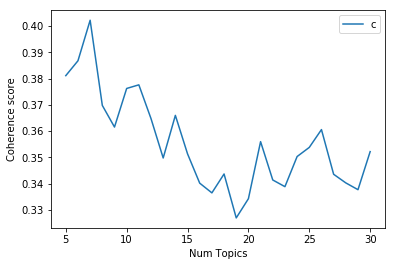

In [29]:
# Show graph
limit=31; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

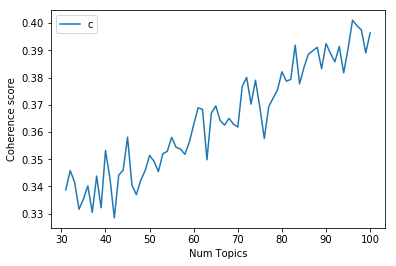

In [19]:
# Show graph
limit=101; start=31; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of 0.3811
Num Topics = 6  has Coherence Value of 0.3868
Num Topics = 7  has Coherence Value of 0.4022
Num Topics = 8  has Coherence Value of 0.3698
Num Topics = 9  has Coherence Value of 0.3616
Num Topics = 10  has Coherence Value of 0.3763
Num Topics = 11  has Coherence Value of 0.3776
Num Topics = 12  has Coherence Value of 0.3648
Num Topics = 13  has Coherence Value of 0.3498
Num Topics = 14  has Coherence Value of 0.366
Num Topics = 15  has Coherence Value of 0.3513
Num Topics = 16  has Coherence Value of 0.3402
Num Topics = 17  has Coherence Value of 0.3365
Num Topics = 18  has Coherence Value of 0.3437
Num Topics = 19  has Coherence Value of 0.3269
Num Topics = 20  has Coherence Value of 0.3342
Num Topics = 21  has Coherence Value of 0.356
Num Topics = 22  has Coherence Value of 0.3414
Num Topics = 23  has Coherence Value of 0.3388
Num Topics = 24  has Coherence Value of 0.3503
Num Topics = 25  has Coherence Value of 0.3538
Num Topics = 26  has